In [1]:
import nfl_data_py as nfl
import pandas as pd

In [19]:
pbp = nfl.import_pbp_data([2022])

2022 done.
Downcasting floats.


In [40]:
df = pbp[(pbp['season_type'] == 'REG') & (pbp['desc'] == 'END GAME')]
# cols = ['home_team', 'away_team', 'home_score', 'away_score']
cols = ['week', 'home_team', 'away_team', 'home_score', 'away_score']
df = df[cols]
df['home_win'] = df['home_score'] > df['away_score']

# home = df[['home_team', 'home_win']].rename(columns={'home_team': 'team', 'home_win': 'win'})
home = df[['week', 'home_team', 'home_win']].rename(columns={'home_team': 'team', 'home_win': 'win'})
# away = df[['away_team', 'home_win']].rename(columns={'away_team': 'team', 'home_win': 'win'})
away = df[['week', 'away_team', 'home_win']].rename(columns={'away_team': 'team', 'home_win': 'win'})
away['win'] = ~away['win']

# Combining the two dataframes
wins = pd.concat([home, away]).reset_index(drop=True)
wins.head()

,week,team,win
0,1,NYJ,False
1,1,LA,False
2,1,CAR,False
3,1,SEA,True
4,1,MIN,True


In [42]:
# win_counts = wins.groupby('team').sum().reset_index()
win_counts = wins.drop(columns=['week']).groupby('team').sum().reset_index()
win_counts.rename(columns={'win': 'win_count'}, inplace=True)
win_counts.sort_values('win_count', ascending=False, inplace=True)
win_counts.head()

,team,win_count
25,PHI,14
15,KC,14
3,BUF,13
20,MIN,13
28,SF,13


In [49]:
pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])

off_epa = pbp_rp.groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'all'})
off_pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass'})
off_epa = pd.merge(off_epa, off_pass_epa, on = 'posteam')
off_rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush'})
off_epa = pd.merge(off_epa, off_rush_epa, on = 'posteam').rename(columns = {'posteam' : 'team'})

def_epa = pbp_rp.groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'all'})
def_pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass'})
def_epa = pd.merge(def_epa, def_pass_epa, on = 'defteam')
def_rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush'})
def_epa = pd.merge(def_epa, def_rush_epa, on = 'defteam').rename(columns = {'defteam' : 'team'})

epa = pd.merge(off_epa, def_epa, on = 'team', suffixes=('_off', '_def'))
epa['net'] = epa['all_off'] - epa['all_def']
epa.sort_values('net').head()

,team,all_off,pass_off,rush_off,all_def,pass_def,rush_def,net
12,HOU,-0.169883,-0.148610,-0.207815,0.011435,0.034373,-0.014940,-0.181318
5,CHI,-0.039965,-0.074289,-0.002024,0.125556,0.214340,0.023884,-0.165521
13,IND,-0.155156,-0.143097,-0.175799,-0.016539,0.045044,-0.099334,-0.138617
16,LA,-0.082841,-0.095503,-0.062047,0.015777,0.094572,-0.099260,-0.098618
0,ARI,-0.079564,-0.079506,-0.079682,0.012586,0.055357,-0.057161,-0.092150


In [47]:
win_counts.to_csv('delete_1.csv', index=False)
epa.to_csv('delete_2.csv', index=False)

In [52]:
df = pd.merge(win_counts, epa, on = 'team')
df.head()

,team,win_count,all_off,pass_off,rush_off,all_def,pass_def,rush_def,net
0,PHI,14,0.114468,0.130672,0.094366,-0.065302,-0.083996,-0.034751,0.179770
1,KC,14,0.181334,0.280231,-0.021943,0.008484,0.040285,-0.056494,0.172850
2,BUF,13,0.090080,0.162691,-0.052620,-0.035789,0.002506,-0.108905,0.125868
3,MIN,13,0.013992,0.081581,-0.124065,0.022088,0.074497,-0.068107,-0.008096
4,SF,13,0.077129,0.179196,-0.042567,-0.090021,-0.062990,-0.139700,0.167149


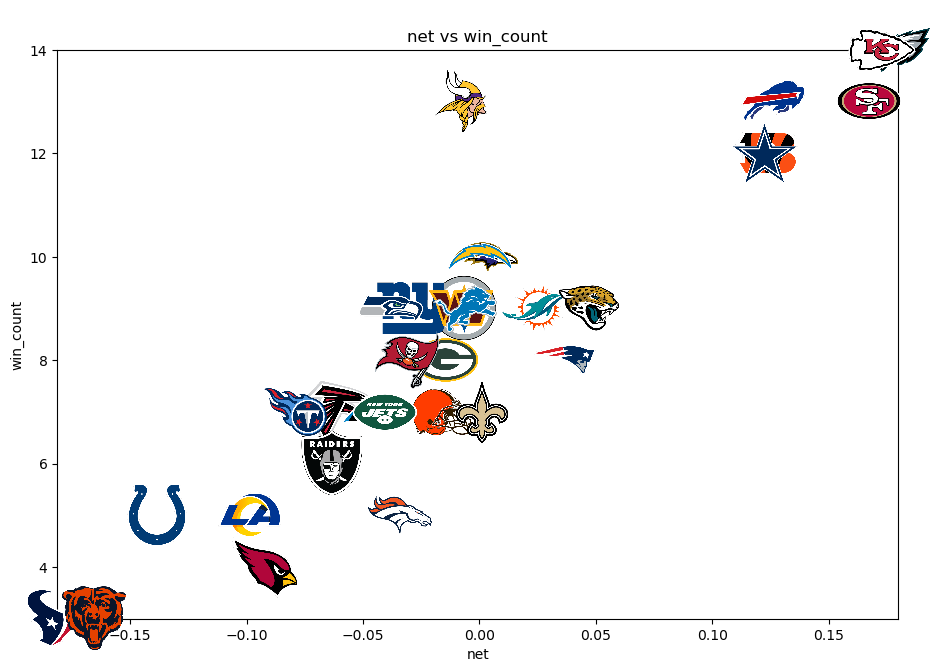

In [56]:
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def chart_epa_vs_wins(df, x_name='net', y_name='win_count'):
    
    logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
    
    logo_paths = []
    team_abbr = []
    if not os.path.exists("logos"):
        os.makedirs("logos")

    for team in range(len(logos)):
        urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
        logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
        team_abbr.append(logos['team_abbr'][team])

    data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
    logo_data = pd.DataFrame(data)

    # epa_with_logos = pd.merge(epa, logo_data, left_on = 'posteam', right_on = 'team_abbr')
    epa_with_logos = pd.merge(df, logo_data, left_on = 'team', right_on = 'team_abbr')

    
    plt.rcParams["figure.figsize"] = [10, 7]
    plt.rcParams["figure.autolayout"] = True

    def getImage(path):
        return OffsetImage(plt.imread(path, format="tif"), zoom=.1)

    # x = epa_with_logos['pass_epa']
    # y = epa_with_logos['rush_epa']
    x = epa_with_logos[x_name]
    y = epa_with_logos[y_name]
    paths = epa_with_logos['logo_path']

    fig, ax = plt.subplots()

    for x0, y0, path in zip(x, y, paths):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

    xmin = min(x)
    xmax = max(x)
    ymin = min(y)
    ymax = max(y)

    # buffer = 0.05
    buffer = 0
    plt.xlim(xmin-buffer, xmax+buffer)
    plt.ylim(ymin-buffer, ymax+buffer)

    # plt.title(f"Rush and Pass EPA, {year}")
    # plt.xlabel("EPA/Pass")
    # plt.ylabel("EPA/Rush")
    plt.title(f"{x_name} vs {y_name}")
    plt.xlabel(f"{x_name}")
    plt.ylabel(f"{y_name}")
    plt.show()
    
chart_epa_vs_wins(df.copy())

In [55]:
correlation = df.corr()['win_count'].drop('win_count')
correlation

C:\Users\grant\AppData\Local\Temp\ipykernel_16944\2705462229.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()['win_count'].drop('win_count')


all_off     0.827880
pass_off    0.840637
rush_off    0.384532
all_def    -0.402120
pass_def   -0.438205
rush_def   -0.181815
net         0.906211
Name: win_count, dtype: float64

In [58]:
import statsmodels.api as sm

# Independent variables (from delete_2)
X = df[['all_off', 'pass_off', 'rush_off', 'all_def', 'pass_def', 'rush_def', 'net']]
# Add a constant to the independent variables (intercept term)
X = sm.add_constant(X)

# Dependent variable
y = df['win_count']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_count   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     22.24
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           4.89e-09
Time:                        11:08:47   Log-Likelihood:                -48.462
No. Observations:                  32   AIC:                             112.9
Df Residuals:                      24   BIC:                             124.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2743      0.456     18.131      0.000       7.332       9.216
all_off     1.219e+08   9.46e+07      1.289      0.210   -7.33e+07    3.17e+08
pass_off     -22.8846     22.672     -1.009      0.323     -69.676      23.907
rush_off     -18.1270     12.922     -1.403      0.173     -44.797       8.543
all_def    -1.219e+08   9.46e+07     -1.289      0.210   -3.17e+08    7.33e+07
pass_def     -29.4841     29.970     -0.984      0.335     -91.340      32.372
rush_def     -18.1191     17.123     -1.058      0.301     -53.459      17.221
net        -1.219e+08   9.46e+07     -1.289      0.210   -3.17e+08    7.33e+07
==============================================================================
Omnibus:                       10.106   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.290
Skew:                           0.887   Prob(JB):                      0.00583
Kurtosis:                       5.137   Cond. No.                     7.33e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.02e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- P-values
    - P-values help us determine the statistical significance of the coefficients. A smaller p-value (typically < 0.05) indicates that you can reject the null hypothesis and that the coefficient is statistically significant.
    - None of the coefficients have p-values less than 0.05, which indicates that at a 95% confidence level, none of the predictors in this model are statistically significant.
- Multicollinearity Warning:
The note at the bottom indicates potential multicollinearity problems. Multicollinearity occurs when independent variables in a regression model are correlated. This can lead to unreliable and unstable estimates of regression coefficients. The variables all_off, all_def, and net seem to be highly correlated, which could be leading to this issue.

In [60]:
# Drop the columns 'all_off', 'all_def', and 'net'
X_refined = df[['pass_off', 'rush_off', 'pass_def', 'rush_def']]
# Add a constant to the independent variables (intercept term)
X_refined = sm.add_constant(X_refined)

# Fit the refined regression model
model_refined = sm.OLS(y, X_refined).fit()

# Get the summary of the refined regression
model_refined_summary = model_refined.summary()
model_refined_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_count   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     34.50
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           3.00e-10
Time:                        11:13:21   Log-Likelihood:                -51.709
No. Observations:                  32   AIC:                             113.4
Df Residuals:                      27   BIC:                             120.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2335      0.446     18.459      0.000       7.318       9.149
pass_off      22.4861      2.595      8.667      0.000      17.163      27.810
rush_off       7.5825      4.110      1.845      0.076      -0.850      16.015
pass_def     -12.4390      3.649     -3.409      0.002     -19.927      -4.951
rush_def      -8.5982      3.967     -2.167      0.039     -16.738      -0.458
==============================================================================
Omnibus:                       12.026   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.215
Skew:                           1.026   Prob(JB):                      0.00135
Kurtosis:                       5.387   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- P-values
    - The p-values for pass_off, pass_def, and rush_def are all less than 0.05, indicating that these predictors are statistically significant at a 95% confidence level.
    - rush_off has a p-value slightly above 0.05, making it marginally significant.
- No Multicollinearity Warning: With the refined model, we don't see any warnings related to multicollinearity, which is a good sign.
- Interpretation
    - An increase in pass_off tends to significantly increase the win_count.
    - Conversely, increases in pass_def and rush_def tend to significantly decrease the win_count.
    - rush_off has a positive effect on the win_count, but the relationship is marginally significant.

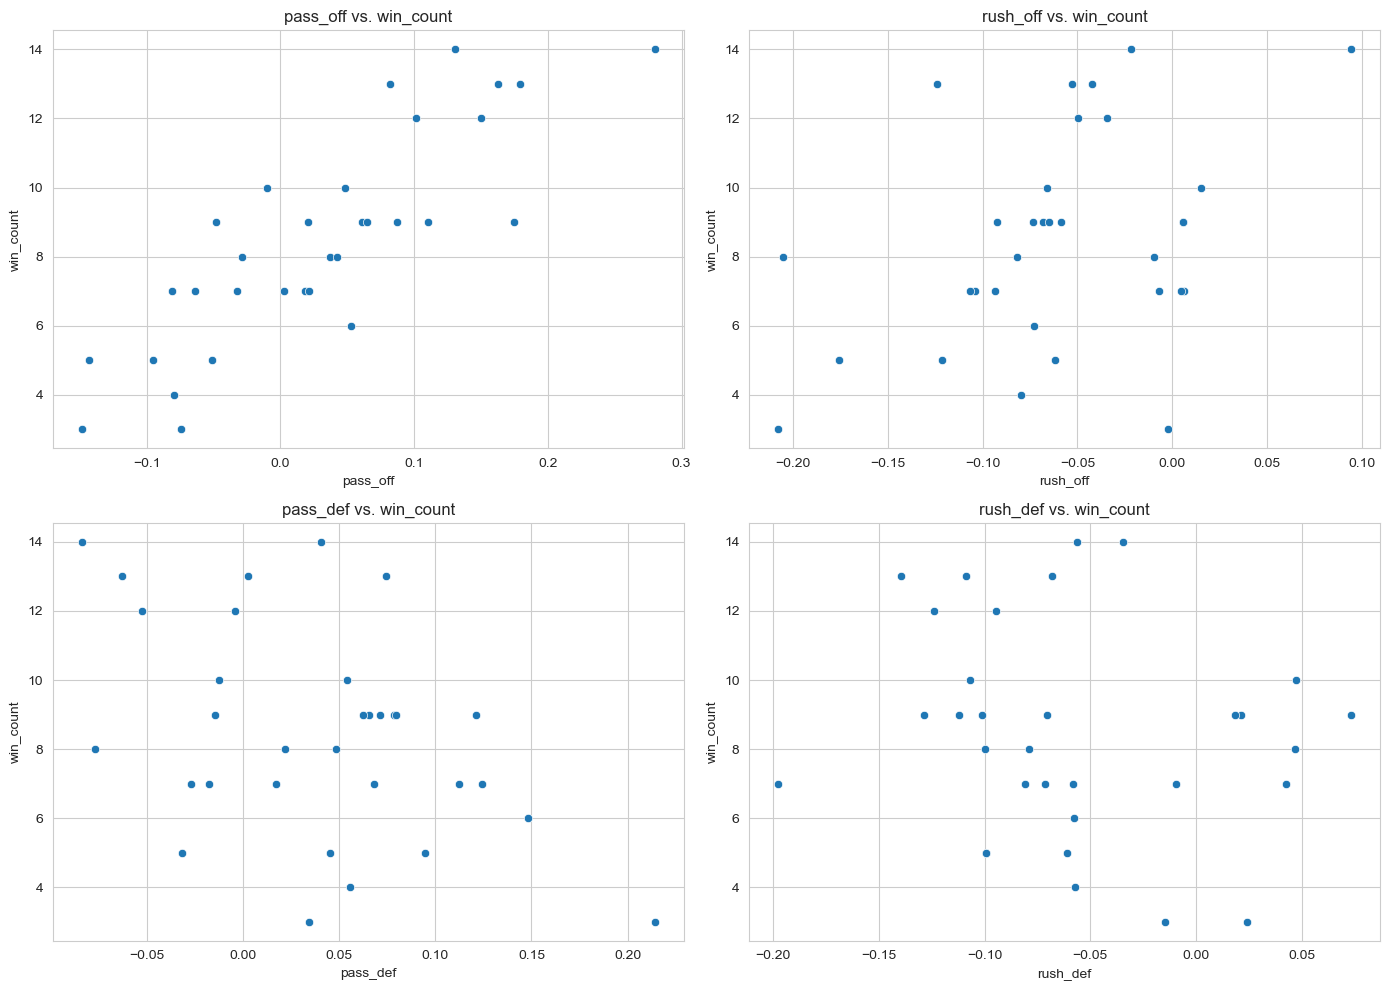

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plots
sns.scatterplot(data=df, x='pass_off', y='win_count', ax=axes[0, 0])
axes[0, 0].set_title('pass_off vs. win_count')

sns.scatterplot(data=df, x='rush_off', y='win_count', ax=axes[0, 1])
axes[0, 1].set_title('rush_off vs. win_count')

sns.scatterplot(data=df, x='pass_def', y='win_count', ax=axes[1, 0])
axes[1, 0].set_title('pass_def vs. win_count')

sns.scatterplot(data=df, x='rush_def', y='win_count', ax=axes[1, 1])
axes[1, 1].set_title('rush_def vs. win_count')

# Adjust the layout
plt.tight_layout()
plt.show()

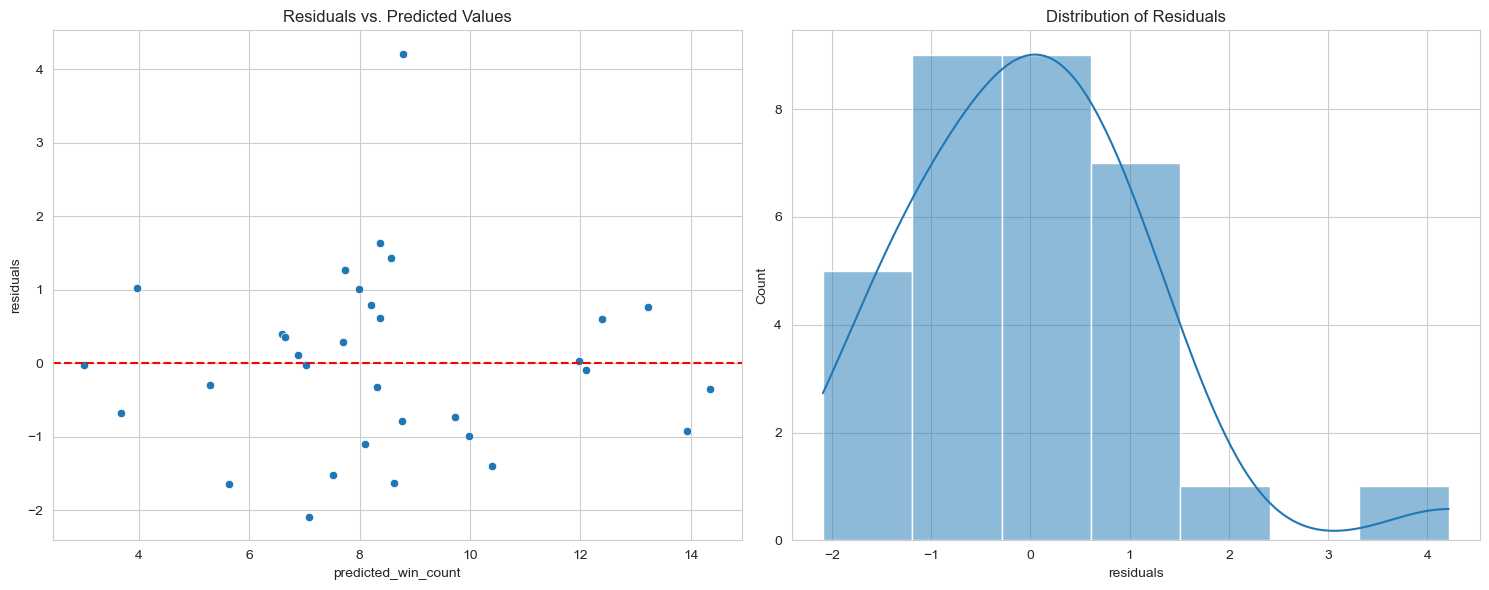

In [63]:
# Calculate residuals and predicted values
df['predicted_win_count'] = model_refined.predict(X_refined)
df['residuals'] = df['win_count'] - df['predicted_win_count']

# Set up the plotting environment
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs. Predicted values
sns.scatterplot(data=df, x='predicted_win_count', y='residuals', ax=axes[0])
axes[0].set_title('Residuals vs. Predicted Values')
axes[0].axhline(y=0, color='r', linestyle='--')

# Distribution of residuals
sns.histplot(data=df, x='residuals', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()


- Residuals vs. Predicted Values
    - The residuals are scattered around the zero line, which is a good indication of linearity.
    - The spread of residuals appears to be fairly consistent across predicted values, suggesting homoscedasticity. There are no clear patterns or funnels in the plot, which would have indicated problems.
- Distribution of Residuals: The residuals seem to be approximately normally distributed, as indicated by the bell-shaped curve.

From this residual analysis, it seems that the assumptions of linear regression are reasonably well met with our refined model.

In [64]:
# Create the interaction term
df['pass_rush_interaction'] = df['pass_off'] * df['rush_off']

# Incorporate the interaction term into the independent variables
X_interaction = X_refined.copy()
X_interaction['pass_rush_interaction'] = df['pass_rush_interaction']

# Fit the regression model with the interaction term
model_interaction = sm.OLS(y, X_interaction).fit()

# Get the summary of the regression with the interaction term
model_interaction_summary = model_interaction.summary()
model_interaction_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_count   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     26.58
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           1.90e-09
Time:                        11:27:13   Log-Likelihood:                -51.708
No. Observations:                  32   AIC:                             115.4
Df Residuals:                      26   BIC:                             124.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.2272      0.495     16.630      0.000       7.210       9.244
pass_off                 22.5783      3.909      5.777      0.000      14.544      30.613
rush_off                  7.5845      4.188      1.811      0.082      -1.025      16.194
pass_def                -12.3891      4.032     -3.073      0.005     -20.677      -4.101
rush_def                 -8.6157      4.079     -2.112      0.044     -17.000      -0.231
pass_rush_interaction     1.3197     41.207      0.032      0.975     -83.383      86.022
==============================================================================
Omnibus:                       12.189   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.505
Skew:                           1.036   Prob(JB):                      0.00117
Kurtosis:                       5.416   Cond. No.                         174.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The coefficient for pass_rush_interaction is 1.3197, but with a very high standard error.
- The p-value for the interaction term is 0.975, which is much greater than 0.05. This indicates that the interaction term is not statistically significant in predicting win_count given our current model.

In simpler terms, the interaction between passing offense (pass_off) and rushing offense (rush_off) doesn't provide additional information about win_count beyond what's already captured by the individual terms.